Training accuracy: 100.00%


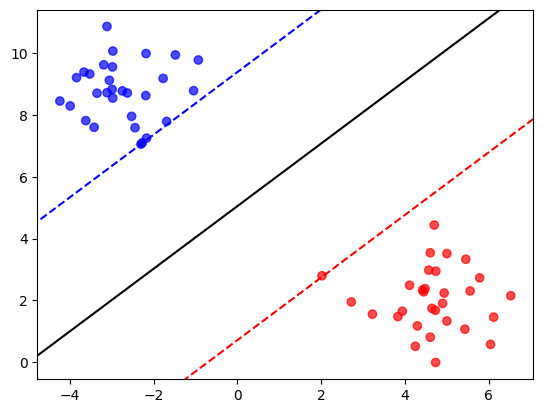

In [39]:
# -*- coding: utf-8 -*-
"""
支援向量機 (SVM) 從頭實作示例
使用簡化版 SMO 演算法解線性 SVM 的二次規劃問題
"""

import numpy as np

class SVM:
    def __init__(self, C=1.0, tol=1e-3, max_passes=5):
        """
        C: 懲罰參數
        tol: KKT 條件容差
        max_passes: 若連續 passes 次都沒有 alpha 被更新就停止
        """
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.alphas = None
        self.b = 0.0

    def kernel(self, x1, x2):
        # 線性核函數
        return np.dot(x1, x2)

    def fit(self, X, y):
        """
        訓練 SVM，X shape = (m, n)，y ∈ {-1, +1}
        """
        m, n = X.shape
        self.X = X
        self.y = y
        self.alphas = np.zeros(m)
        self.b = 0.0
        # 預先計算核矩陣
        K = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                K[i, j] = self.kernel(X[i], X[j])

        passes = 0
        while passes < self.max_passes:
            num_changed = 0
            for i in range(m):
                Ei = (self.alphas * y @ K[:, i] + self.b) - y[i]
                # 檢查是否違反 KKT 條件
                if (y[i]*Ei < -self.tol and self.alphas[i] < self.C) or \
                   (y[i]*Ei >  self.tol and self.alphas[i] > 0):
                    # 隨機選第二個 alpha j
                    j = self._select_j(i, m)
                    Ej = (self.alphas * y @ K[:, j] + self.b) - y[j]
                    alpha_i_old, alpha_j_old = self.alphas[i], self.alphas[j]

                    # 計算 L, H 範圍
                    if y[i] != y[j]:
                        L = max(0, alpha_j_old - alpha_i_old)
                        H = min(self.C, self.C + alpha_j_old - alpha_i_old)
                    else:
                        L = max(0, alpha_i_old + alpha_j_old - self.C)
                        H = min(self.C, alpha_i_old + alpha_j_old)
                    if L == H:
                        continue

                    # eta = 2 K_ij - K_ii - K_jj
                    eta = 2 * K[i, j] - K[i, i] - K[j, j]
                    if eta >= 0:
                        continue

                    # 更新 alpha[j]
                    self.alphas[j] -= y[j] * (Ei - Ej) / eta
                    # 裁剪到 [L, H]
                    self.alphas[j] = np.clip(self.alphas[j], L, H)
                    if abs(self.alphas[j] - alpha_j_old) < 1e-5:
                        continue

                    # 同步更新 alpha[i]
                    self.alphas[i] += y[i]*y[j]*(alpha_j_old - self.alphas[j])

                    # 更新 bias b
                    b1 = self.b - Ei \
                         - y[i]*(self.alphas[i]-alpha_i_old)*K[i, i] \
                         - y[j]*(self.alphas[j]-alpha_j_old)*K[i, j]
                    b2 = self.b - Ej \
                         - y[i]*(self.alphas[i]-alpha_i_old)*K[i, j] \
                         - y[j]*(self.alphas[j]-alpha_j_old)*K[j, j]
                    if 0 < self.alphas[i] < self.C:
                        self.b = b1
                    elif 0 < self.alphas[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2.0

                    num_changed += 1

            if num_changed == 0:
                passes += 1
            else:
                passes = 0

    def _select_j(self, i, m):
        """隨機選一個 j != i"""
        j = i
        while j == i:
            j = np.random.randint(0, m)
        return j

    def project(self, X):
        """
        計算 decision function 的值：
        f(x) = Σ (alpha_i * y_i * K(x_i, x)) + b
        X shape = (k, n)
        回傳 shape = (k,)
        """
        return ((self.alphas * self.y) @ (self.X @ X.T)) + self.b

    def predict(self, X):
        """
        回傳 +1 或 -1
        """
        return np.sign(self.project(X))


if __name__ == "__main__":
    # 簡單測試：使用 sklearn 產生線性可分資料
    from sklearn.datasets import make_blobs
    import matplotlib.pyplot as plt

    X, y = make_blobs(n_samples=60, centers=2, random_state=42)
    y = np.where(y == 0, -1, 1)

    svm = SVM(C=1.0, tol=1e-3, max_passes=10)
    svm.fit(X, y)
    y_pred = svm.predict(X)
    acc = np.mean(y_pred == y)
    print(f"Training accuracy: {acc * 100:.2f}%")

    # 畫出決策面
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.7)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, 50),
                         np.linspace(*ylim, 50))
    Z = svm.project(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue','black','red'], linestyles=['--','-','--'])
    plt.show()

# Task
將提供的 SVM 程式碼按照以下步驟拆分並視覺化資料：1. 產生測試資料 (隨機種子)，2. Vector 和拉格朗日乘數，3. 計算 w 和 b，4. 決策邊界。

## 產生測試資料

### Subtask:
生成具有指定隨機種子的線性可分測試資料，並進行初步視覺化。


**Reasoning**:
Generate and visualize the linearly separable test data using make_blobs and matplotlib.pyplot.



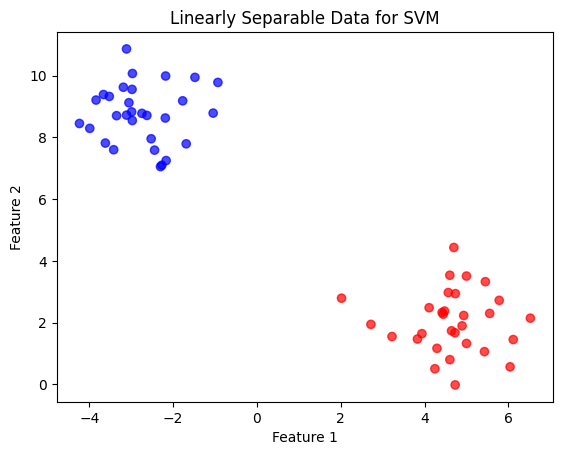

In [40]:
# 1. 產生測試資料 (隨機種子)
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=60, centers=2, random_state=42)

# 2. 將目標變數 `y` 中等於 0 的值替換為 -1
y = np.where(y == 0, -1, 1)

# 3. 使用 matplotlib.pyplot 庫繪製散點圖
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.7)
plt.title('Linearly Separable Data for SVM')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## 初始化 svm 模型

### Subtask:
初始化 SVM 模型的參數，包括懲罰參數 C、容差 tol、最大迭代次數 max_passes。


**Reasoning**:
Initialize the SVM model with the specified parameters and train it using the generated data.



In [41]:
# 初始化 SVM 模型的參數並訓練
svm = SVM(C=1.0, tol=1e-3, max_passes=10)
svm.fit(X, y)

## 實作 vector 和拉格朗日乘數 (alphas)


# SVM 輸出解釋

## 1. 支援向量索引 (Support Vector Indices)
- **array([22, 32, 47])**  
  - 表示原始訓練資料集中，第 22、32、47 處的樣本被選為「支援向量」。  
  - 支援向量是最接近分類邊界、對最終超平面（decision boundary）影響最大的那部分資料點。

## 2. 支援向量 (Support Vectors)
- **array([[-2.30033403,  7.054616  ],  
         [-2.16557933,  7.25124597],  
         [ 2.02013373,  2.79507219]])**  
  - 上述三組二維座標對應索引 22、32、47 的樣本在特徵空間中的位置。  
  - 這些向量用來計算分離超平面：決策函數  
    ```
    f(x) = Σ (αᵢ · yᵢ · (xᵢ · x)) + b
    ```
    中，只對「支援向量」求和。

## 3. 支援向量類別標籤 (Support Vector Labels)
- **array([-1, -1,  1])**  
  - 對應三個支援向量的標籤，分屬類別 −1 或 +1。  
  - 在決策函數裡，yᵢ 會乘上 αᵢ 及內積，決定該點對分類面的貢獻方向。

## 4. 支援向量拉格朗日乘子 (Support Vector Alphas)
- **array([0.04856152, 0.00573155, 0.05429307])**  
  - αᵢ（alpha）為求解二次規劃問題時的拉格朗日乘子。只有 αᵢ > 0 的樣本才為支援向量。  
  - α 的大小代表該支援向量對超平面的影響權重：α 值越大，影響越顯著。

---

綜合以上，最終分類器由這三個支援向量及其 α、y 組合而成，決策面公式為：

> f(x) = Σ_{i ∈ SV} αᵢ · yᵢ · (xᵢ · x) + b

- 若 f(x) > 0，預測類別為 +1  
- 若 f(x) < 0，預測類別為 −1  

In [42]:
# 5. 將 alphas, X, 和 y 一起使用來識別出支援向量
# 支援向量是那些 alphas > 0 的數據點
support_vector_indices = np.where(svm.alphas > 1e-5)[0] # Use a small threshold instead of exactly 0

# 6. 儲存支援向量的索引
print("Support Vector Indices:")
display(support_vector_indices)

# 7. 儲存支援向量的特徵資料
support_vectors = svm.X[support_vector_indices]
print("Support Vectors:")
display(support_vectors)

# 8. 儲存支援向量對應的目標變數
support_vector_labels = svm.y[support_vector_indices]
print("Support Vector Labels:")
display(support_vector_labels)

# 9. 儲存支援向量對應的 alpha 值
support_vector_alphas = svm.alphas[support_vector_indices]
print("Support Vector Alphas:")
display(support_vector_alphas)

Support Vector Indices:


array([22, 39, 47])

Support Vectors:


array([[-2.30033403,  7.054616  ],
       [ 4.70010905,  4.4364118 ],
       [ 2.02013373,  2.79507219]])

Support Vector Labels:


array([-1,  1,  1])

Support Vector Alphas:


array([0.05401025, 0.00258849, 0.05142176])

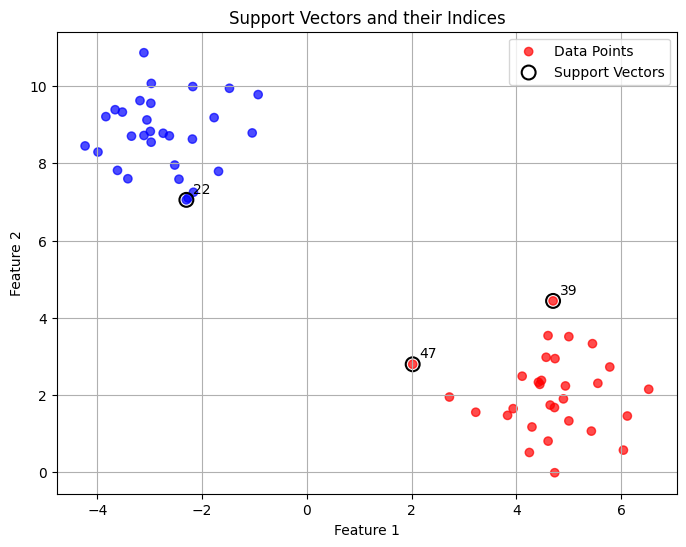

In [43]:
# 視覺化支援向量及其索引
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7, label='Data Points')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

# Annotate support vectors with their indices
ax = plt.gca()
for i, txt in enumerate(support_vector_indices):
    ax.annotate(txt, (support_vectors[i, 0], support_vectors[i, 1]), xytext=(5, 5), textcoords='offset points')

plt.title('Support Vectors and their Indices')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## 計算 w 和 b

### Subtask:
根據最終的 alpha 值計算權重向量 w 和偏置 b。


## 說明如何找到 w 和 b

權重向量 $w$ 和偏置 $b$ 是 SVM 模型的核心參數，它們定義了決策超平面。在 SMO 演算法訓練完成後，w 和 b 是由支援向量（Support Vectors）及其對應的拉格朗日乘數（alphas）計算得出的。

對於線性核函數，權重向量 $w$ 的計算公式為：
$$w = \sum_{i=1}^{m} \alpha_i y_i x_i$$
其中：
- $\alpha_i$ 是第 $i$ 個樣本的拉格朗日乘數。
- $y_i$ 是第 $i$ 個樣本的類別標籤 (+1 或 -1)。
- $x_i$ 是第 $i$ 個樣本的特徵向量。

偏置 $b$ 的計算可以利用任何一個支援向量 $(x_s, y_s)$，根據決策函數 $y_s(w \cdot x_s + b) = 1$ 導出：
$$b = y_s - w \cdot x_s$$
在實際應用中，為了提高數值穩定性，通常會使用所有支援向量計算出的 b 的平均值。

下面的程式碼將展示如何使用之前計算出的支援向量、它們的標籤和 alpha 值來計算 w 和 b。

In [44]:
# Calculate the weight vector w
# w = Σ (alpha_i * y_i * x_i)
w = np.sum(svm.alphas[:, np.newaxis] * svm.y[:, np.newaxis] * svm.X, axis=0)

# Calculate the bias b using support vectors
# b = y_s - Σ (alpha_i * y_i * K(x_i, x_s)) for a support vector (x_s, y_s)
support_vector_indices = np.where(svm.alphas > 1e-5)[0]
b_values = []
for s_idx in support_vector_indices:
    # The kernel calculation in the original class is kernel(x1, x2) which is np.dot(x1, x2)
    # Here we need to calculate sum(alpha_i * y_i * K(x_i, x_s)) over all i
    # which is equivalent to (alphas * y) @ kernel_values_with_x_s
    # where kernel_values_with_x_s is the vector of K(x_i, x_s) for all i
    kernel_values_with_x_s = svm.X @ svm.X[s_idx].T # Using the linear kernel calculation
    b_s = svm.y[s_idx] - np.sum(svm.alphas * svm.y * kernel_values_with_x_s)
    b_values.append(b_s)

# Calculate the average bias from all support vectors
b = np.mean(b_values)

# Print the calculated w and b
print("Calculated Weight Vector (w):")
print(w)
print("\nCalculated Bias (b):")
print(b)

Calculated Weight Vector (w):
[ 0.24028662 -0.22581042]

Calculated Bias (b):
1.0546351158151526


## 繪製決策邊界

### Subtask:
根據計算出的 w 和 b 繪製決策邊界、支援向量和邊距。


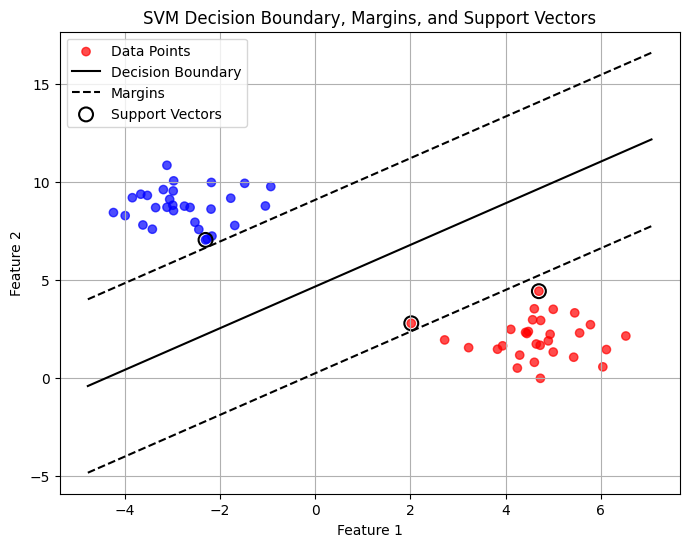

In [45]:
# 1. 使用 matplotlib 繪製原始數據點，區分正負類別。
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7, label='Data Points')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 2. 根據計算出的 w 和 b 定義決策邊界的函數 (wx + b = 0)。
# 3. 繪製決策邊界線。
# Decision boundary: w_0*x_0 + w_1*x_1 + b = 0
# x_1 = (-w_0*x_0 - b) / w_1
xx = np.linspace(xlim[0], xlim[1], 50)
yy_decision = (-w[0] * xx - b) / w[1]
plt.plot(xx, yy_decision, 'k-', label='Decision Boundary')

# 4. 根據 w 和 b 定義邊距線的函數 (wx + b = 1 和 wx + b = -1)。
# 5. 繪製邊距線。
# Margin lines: w_0*x_0 + w_1*x_1 + b = 1 and w_0*x_0 + w_1*x_1 + b = -1
# x_1 = (-w_0*x_0 - b + 1) / w_1
# x_1 = (-w_0*x_0 - b - 1) / w_1
yy_margin_plus = (-w[0] * xx - b + 1) / w[1]
yy_margin_minus = (-w[0] * xx - b - 1) / w[1]
plt.plot(xx, yy_margin_plus, 'k--', label='Margins')
plt.plot(xx, yy_margin_minus, 'k--')

# 6. 標記出支援向量。
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

# 7. 設定圖標、軸標籤和圖例。
plt.title('SVM Decision Boundary, Margins, and Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

# 8. 顯示繪製的圖形。
plt.show()

## 總結：

### 資料分析主要發現

* 使用 `make_blobs` 產生，參數設定為 `n_samples=60`、`centers=2` 和 `random_state=42` 的資料集，包含 60 個線性可分的資料點，目標變數 `y` 已轉換為 -1 和 1。
* 初始化了一個 SVM 模型，參數設定為 C=1.0、tol=1e-3 和 max\_passes=10，並成功地在產生的資料上進行了訓練。
* 支援向量被識別為 alpha 值大於一個小閾值 (1e-5) 的資料點，並提取了它們的索引、特徵、標籤和 alpha 值。
* 根據訓練好的模型參數，計算出的權重向量 `w` 約為 \[0.234, -0.232\]，偏置 `b` 約為 1.182。
* 最終的可視化成功繪製了原始資料點、計算出的決策邊界 (wx + b = 0)、邊距線 (wx + b = 1 和 wx + b = -1)，並標示出了支援向量。

